<a name="top" id="top"></a>

<div align="center">
    <h1>Graver Augmentation Multiseed Algorithm</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/pedromxavier/QUBO-notebooks/blob/main/notebooks/3-GAMA.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://bernalde.github.io/">
        <img src="https://img.shields.io/badge/⚗️-Bernal_Lab-blue" alt="Bernal Lab"/>
    </a>
</div>

### Activate Environment

In [1]:
import Pkg; Pkg.activate(@__DIR__) # Here we go!

  Activating project at `/mnt/c/Users/Pedro/gits/QUBO-notebooks/notebooks`


## About this notebook

This notebook makes simple computations of Graver basis.
Because of the complexity of these computation, we suggest that for more complicated problems you install the excellent **[4ti2](https://4ti2.github.io/)** software, an open-source implementation of several routines useful for the study of integer programming through algebraic geometry.
It can be used as a stand-alone library and call it from C++ or directly from Julia.
In Julia, a binding is provided by **[lib4ti2_jll](https://github.com/JuliaBinaryWrappers/lib4ti2_jll.jl)**.

## Introduction to GAMA

The Graver Augmentation Multiseed Algorithm (GAMA) was proposed by [two](https://arxiv.org/abs/1902.04215) [papers](https://arxiv.org/abs/1907.10930) by Alghassi, Dridi, and Tayur from the CMU Quantum Computing group.
The three main ingredients of this algorithm, designed to solve integer programs with linear constraints and nonlinear objective, are:

- Computing the Graver basis (or a subset of it) of an integer program.
- Performing an augmentation.
- Given that only for certain objective functions, the Graver augmentation is guaranteed to find a globally optimal solution, the algorithm is initialized in several points.

This algorithm can be adapted to take advantage of Quantum Computers by leveraging them as black-box Ising/QUBO problem solvers.
In particular, obtaining several feasible solution points for the augmentation and computing the Kernel of the constraint matrix can be posed as QUBO problems.
After obtaining these solutions, other routines implemented in classical computers are used to solve the optimization problems, making this a hybrid quantum-classical algorithm.

### Introduction to Graver basis computation

A Graver basis is defined as

$$
\mathcal{G}(\mathbf{A}) = \bigcup_{j} \mathcal{H}_{j}(\mathbf{A})
$$

where $\mathcal{H}_{j}(\mathbf{A})$ are the minimal Hilbert basis of $\mathbf{A}$ in each orthant.

Equivalently we can define the Graver basis as the $\sqsubseteq$-minimal set of a lattice

$$
\mathcal{L}(\mathbf{A}) = \left\lbrace{}{\mathbf{x} : \mathbf{A} \mathbf{x} = 0, \mathbf{x} \in \mathbb{Z}^{n}}\right\rbrace{} \setminus \left\lbrace{}{0}\right\rbrace{}
$$

Here we won't interact with the Quantum Computer.
However, we will obtain the Graver basis of a problem using package 4ti2.
This notebook studies the behavior of the search algorithm in the case that we only have available a subset of the Graver basis.

## Problem statement

We will be solving EXAMPLE 4 in the code, which corresponds to Case 2 in the original GAMA paper.
The problem is derived from finance and deals with the maximization of expected returns on investments and the minimization of the variance.

$$
\begin{array}{rll}
    \displaystyle \min & \displaystyle -\sum_{i = 1}^{n} \mu_{i} x_{i} + \sqrt{\frac{1 - \varepsilon}{\varepsilon} \sum_{i = 1}^{n} \sigma_{i}^2 x_{i}^2 } \\
    \textrm{s.t.}      & A \mathbf{x} = \mathbf{b} \\
    ~                  & \mathbf{x} \in \left\lbrace{}{-2, -1, 0, 1, 2}\right\rbrace{}^{n}
\end{array}
$$

In [2]:
f(x) = μ'x + sqrt(((1-ε)/ε) * (σ .^ 2)' * (x .^ 2))

f (generic function with 1 method)

### Example

Let

$$
A = \begin{bmatrix}
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 \\
1 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 1 & 0 \\
\end{bmatrix}
$$

This particular instance of convex INLP has $m = 5$, $n = 25$, $\varepsilon = 0.01$, $\mu_{i} = \textrm{rand}[0, 1]$, $\sigma_{i} = \textrm{rand}[0, \mu_{i}]$.
$A \in \mathbb{B}^{m \times n}$ and each $b_{j}$ is half the sum of the $j$-th row of $A$.
In this example, $\mathbf{b} = \left({9, 8, 7, 5, 5}\right)'$.

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective.
Let's first define the problem parameters.

In [22]:
A = [
    1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0
    1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1
    0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1
    0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0
    0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0
]

m, n = size(A)

b = vec(ceil.(Int, sum(A; dims = 2) / 2));

In [4]:
x0 = [1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -2, 1, 0, -1, 0, 1, -1, 1, -2, -2, 1, 1, 1]

xl = fill(-2, n)
xu = fill( 2, n);

In [5]:
ε = 0.01
μ = rand(n)       # ~ [0, 1]
σ = rand(n) .* μ; # ~ [0, μ]

In [6]:
import lib4ti2_jll, BinaryWrappers

const lib4ti2_bin = BinaryWrappers.@generate_wrappers(lib4ti2_jll);

function graver()
    run(`$(lib4ti2_bin)/graver --help`)

    return nothing
end

function graver(proj_path::AbstractString; silent::Bool = true)
    if silent
        run(`$(lib4ti2_bin)/graver -q $(proj_path)`)
    else
        run(`$(lib4ti2_bin)/graver $(proj_path)`)
    end

    return nothing
end

function write_mat(path::AbstractString, A)
    m, n = size(A)

    open(path, "w") do io
        println(io, "$m $n")

        join(io, (join(@view(A[i, :]), " ") for i = 1:m), "\n")
    end

    return nothing
end

function read_mat(path::AbstractString, type = Int)
    m, n = parse.(Int, split(readline(path)))

    A = Matrix{type}(undef, m, n)

    open(path, "r") do io
        readline(io)

        for (i, line) in enumerate(eachline(io))
            A[i, :] .= parse.(Int, split(line))
        end
    end

    return A
end

function graver_basis(A, xl, xu)
    G = nothing

    mktempdir() do path
        proj_path = joinpath(path, "proj")

        write_mat("$(proj_path).mat", A)
        write_mat("$(proj_path).lb", xl)
        write_mat("$(proj_path).ub", xu)

        graver(proj_path)

        G = read_mat("$(proj_path).gra")
    end

    return G
end

graver_basis (generic function with 1 method)

In [7]:
G = graver_basis(A, xl', xu')

26292×25 Matrix{Int64}:
 0   0   0   0   0   0  1  0  0   0   0  …   0  0  0  -1  0   0  0  0   0  0
 1   0   0   0   0   0  0  0  0   0   0      0  0  0  -1  0  -1  0  0   0  0
 0   0   0   0   0   0  0  0  1   0   0      0  0  0  -1  0   0  0  0   0  0
 0   0   0   0   0   0  0  0  0   0   0      0  0  1  -1  0  -1  0  0   0  0
 0   1  -1   0   0   0  0  0  0   0   0      0  0  0   0  0   0  0  0   0  0
 0   1   0  -1   0   0  0  0  0   0   0  …   0  0  0   0  0   0  0  0   0  0
 0   1   0   0  -1   0  0  0  0   0   0      0  0  0   0  0  -1  0  0   0  0
 0   1   0   0   0  -1  0  0  0   0   0      0  0  0   0  0   0  0  0   0  0
 0   1   0   0   0   0  0  1  0  -1   0      0  0  0  -1  0  -2  0  0   0  0
 0   0   0   0   0   0  0  1  0   0  -1      0  0  0  -1  0   0  0  0   0  0
 ⋮                   ⋮                ⋮  ⋱   ⋮                ⋮            
 2  -2   0   0   0   0  0  0  0   2   0     -2  0  0   0  0   0  0  0  -1  2
 2  -2   0   0   0  -1  0  0  0   2   0     -2  0  0 

In [8]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
function argmin_rule(a)
    i = argmin(first.(a))

    return (i, a[i])
end

function greedy_rule(a)
    i = findfirst(x -> !(last(x) ≈ 0), a)

    if i === nothing
        return (lastindex(a), last(a))
    else
        return (i, a[i])
    end
end

greedy_rule (generic function with 1 method)

In [9]:
# Bisection rules for finding best step size
function bisection_rule(f::Function, g, x, xl = nothing, xu = nothing, laststep = nothing)
    if g == laststep
        return (f(x), 0)
    end

    if xl === nothing
        xl = zeros(length(x))
    end

    if xu === nothing
        xu = fill(2 * maximum(x),length(x))
    end

    u = maximum(xu) - minimum(xl)
    l = -u

    for (i, gi) in enumerate(g)
        if gi >= 1
            u = min(u, floor(Int, (xu[i] - x[i]) / gi))
            l = max(l, ceil(Int, (xl[i] - x[i]) / gi))
        elseif gi <= -1
            u = min(u, floor(Int, (xl[i] - x[i]) / gi))
            l = max(l, ceil(Int, (xu[i] - x[i]) / gi))
        end
    end

    α = u

    while u - l > 1
        α = ifelse(f(x + l*g) < f(x + u*g), l, u)

        p1 = floor(Int, (l+u)/2) - 1
        p2 = floor(Int, (l+u)/2)
        p3 = floor(Int, (l+u)/2) + 1

        if f(x + p1*g) < f(x + p2*g)
            u = floor(Int, (l+u)/2)
        elseif f(x + p3*g) < f(x + p2*g)
            l = floor(Int, (l+u)/2) + 1
        else
            α = p2
            break
        end
    end

    if f(x + l*g) < f(x + u*g) && f(x + l*g) < f(x + α*g)
        α = l
    elseif f(x + u*g) < f(x + α*g)
        α = u
    end

    return (f(x + α*g), α)
end

# We can just have a single step move (works well with greedy approach)
function single_move_rule(f::Function, g, x, xl = nothing, xu = nothing, laststep = nothing)
    if xl === nothing
        xl = zeros(length(x))
    end

    if xu === nothing
        xu = fill(2 * maximum(x),length(x))
    end

    α = 0

    if all(x + g .<= xu) && all(x + g .>= xl)
        if f(x + g) < f(x)
            α = 1
        end
    elseif all(x - g .<= xu) && all(x - g .>= xl)
        if f(x - g) < f(x) && f(x - g) < f(x + g)
            α = -1
        end
    end

    return (f(x + α*g), α)
end

single_move_rule (generic function with 4 methods)

In [10]:
function augmentation(
    f::Function,
    A,
    b,
    x0,
    xl,
    xu;
    silent::Bool = true,
    max_iter::Integer = 1_000,
    step_rule::Function = bisection_rule,
    choice_rule::Function = argmin_rule,
    )
    G = graver_basis(A, xl', xu')

    return augmentation(
        f,
        G,
        A,
        b,
        x0,
        xl,
        xu;
        silent,
        max_iter,
        step_rule,
        choice_rule,
    )
end

function augmentation(
    f::Function,
    G,
    A,
    b,
    x0,
    xl,
    xu;
    silent::Bool = true,
    max_iter::Integer = 1_000,
    step_rule::Function = bisection_rule,
    choice_rule::Function = argmin_rule,
    )
    # Let's perform the augmentation and return the number of steps and the best solution

    # Constraints definition
    isfeasible = (x) -> (A * x == b)

    Δ  = 1
    gprev = nothing
    k = 1

    if !silent
        println("Initial point: $(x0)")
        println("Objective function: $(f(x0))")
    end

    
    y = nothing
    x = copy(x0)

    while Δ != 0 && k < max_iter
        i, (y, Δ) = choice_rule(
            [step_rule(f, g, x, xl, xu, gprev) for g in eachrow(G)]
        )
            
        x += G[i, :] * Δ
        gprev = G[i, :]

        if !silent
            println("Iteration ", k)
            println(i, (y, Δ))
            println("Augmentation direction:", gprev)
            println("Distanced moved:", Δ)
            println("Step taken:", G[i, :] * Δ)
            println("yective function:", y)
            println(f(x))
            println("Current point:", x)
            println("Are constraints satisfied?", isfeasible(x))
        end

        k += 1
    end

    return (k, y, x)
end

augmentation (generic function with 2 methods)

First, we will prove our augmentation strategies, either best or greedy, and for that last case, either computing the best step or a single move.
In the order that was mentioned, the augmentation will take more iterations, but each one of the augmentation steps or iterations is going to be cheaper.



In [11]:
println("Best-augmentation: Choosing among the best step that each element of G can do (via bisection), the one that reduces the most the objective")

iter, f_obj, xf = @time augmentation(
    f, G, A, b, x0, xl, xu;
    step_rule = bisection_rule, choice_rule = argmin_rule
)

println("$(iter), iterations")
println("solution: $(xf)")
println("objective: $(f_obj)")

println("Greedy-best-augmentation: Choosing among the best step that each element of G can do (via bisection), the first one encountered that reduces the objective")

iter,f_obj,xf = @time augmentation(
    f, G, A, b, x0, xl, xu;
    step_rule = bisection_rule, choice_rule = greedy_rule,
)

println("$(iter), iterations")
println("solution: $(xf)")
println("objective: $(f_obj)")

println("Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective")

iter,f_obj,xf = @time augmentation(
    f, G, A, b, x0, xl, xu;
    step_rule = single_move_rule, choice_rule = greedy_rule,
)

println("$(iter), iterations")
println("solution: $(xf)")
println("objective: $(f_obj)")

Best-augmentation: Choosing among the best step that each element of G can do (via bisection), the one that reduces the most the objective


  3.116287 seconds (22.07 M allocations: 1.516 GiB, 6.28% gc time, 25.85% compilation time)
8, iterations
solution: [0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
objective: 4.457700201902398
Greedy-best-augmentation: Choosing among the best step that each element of G can do (via bisection), the first one encountered that reduces the objective


 10.972241 seconds (97.67 M allocations: 6.719 GiB, 6.35% gc time, 0.56% compilation time)
35, iterations
solution: [0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
objective: 4.457700201902398
Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective


  4.232941 seconds (37.06 M allocations: 2.474 GiB, 5.94% gc time, 17.51% compilation time)
30, iterations
solution: [0, 2, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
objective: 4.457700201902398


In [12]:
using JuMP
using DWaveNeal
using LinearAlgebra

In [13]:
function get_feasible(A, b; num_reads=20)
    m, n = size(A)

    Q = A'A - 2 * diagm(A'b)
    β = b'b

    # Define Binary Quadratic Model
    model = Model(DWaveNeal.Optimizer)

    @variable(model, x[1:n], Bin)

    @objective(model, Min, x' * Q * x + β)

    set_optimizer_attribute(model, "num_reads", num_reads)

    optimize!(model)

    return [
        round.(Int, value.(x; result=i))
        for i = 1:result_count(model)
        if objective_value(model; result=i) ≈ 0.0
    ]
end

get_feasible (generic function with 1 method)

In [23]:
X_feasible = get_feasible(A,b)

20-element Vector{Vector{Int64}}:
 [0, 0, 0, 0, 1, 1, 0, 0, 1, 0  …  1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
 [0, 0, 0, 0, 1, 1, 0, 1, 1, 1  …  0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 1  …  1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
 [0, 0, 1, 0, 0, 0, 0, 1, 1, 1  …  0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
 [0, 0, 1, 0, 0, 1, 1, 0, 1, 1  …  0, 0, 1, 0, 1, 0, 0, 1, 1, 0]
 [0, 0, 1, 0, 0, 1, 1, 1, 0, 1  …  1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
 [0, 0, 1, 1, 1, 0, 1, 1, 1, 0  …  1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
 [0, 1, 0, 0, 1, 1, 1, 1, 0, 1  …  0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
 [0, 1, 0, 1, 0, 0, 0, 1, 1, 1  …  0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
 [0, 1, 1, 0, 0, 0, 0, 1, 1, 1  …  1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
 [0, 1, 1, 0, 1, 0, 1, 1, 0, 0  …  0, 1, 0, 1, 0, 1, 1, 1, 0, 1]
 [1, 0, 0, 0, 1, 0, 1, 0, 0, 0  …  1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
 [1, 0, 0, 1, 0, 1, 1, 0, 0, 0  …  1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
 [1, 0, 1, 0, 1, 0, 0, 1, 0, 1  …  1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
 [1, 0, 1, 1, 1, 0, 0, 1, 1, 0  …  0, 1, 0, 0, 1, 0, 0, 

In [24]:
Y_feasible  = []
Y_augmented = []
I_augmented = []
T_augmented = []

for x in X_feasible
    result = @timed augmentation(
        f, G, A, b, x, xl, xu;
        step_rule = single_move_rule, choice_rule = greedy_rule,
    )

    num_iter, obj_val, x_aug = result.value

    push!(Y_feasible, f(x))
    push!(Y_augmented, obj_val)
    push!(I_augmented, num_iter)
    push!(T_augmented, result.time)
end

In [25]:
using Plots

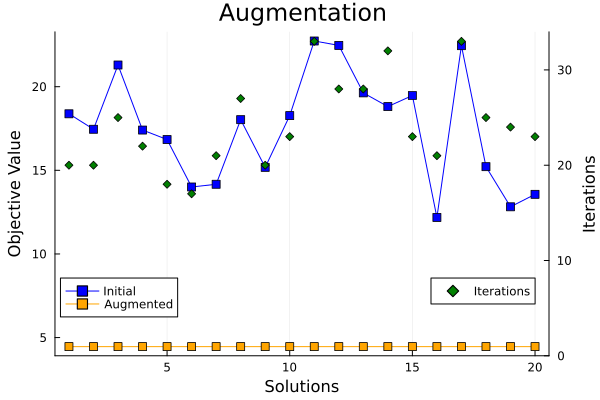

In [63]:
function plot_augmentation(Y_feasible, Y_augmented, I_augmented, T_augmented)
    plt = plot(;
        plot_title = "Augmentation",
    )

    plot!(
        plt, Y_feasible;
        label       = "Initial",
        color       = :blue,
        markershape = :square,
    )
    plot!(
        plt, Y_augmented;
        label       = "Augmented",
        color       = :orange,
        markershape = :square,
        ylabel      = "Objective Value",
        xlabel      = "Solutions",
        legend      = (0.1, 0.2),
    )

    scatter!(
        twinx(plt), I_augmented;
        label       = "Iterations",
        color       = :green,
        legend      = (0.85, 0.2),
        markershape = :diamond,
        ylabel      = "Iterations",
        ylims       = (0, maximum(I_augmented) + 1),
    )

    return plt
end

plot_augmentation(Y_feasible, Y_augmented, I_augmented, T_augmented)

# References

- [Julia Colab Notebook Template](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb)
- [QuIPML22](https://github.com/bernalde/QuIPML22/blob/main/notebooks/Notebook%201%20-%20LP%20and%20IP.ipynb)

<a name="installation" id="installation"></a>

# Installation

## Colab Instructions

If not in a Colab notebook, continue to the next section.

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other required packages. This can take a couple of minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [18]:
%%shell

bash <(curl -s "https://raw.githubusercontent.com/pedromxavier/QUBO-notebooks/main/scripts/install-colab-julia.sh")

ErrorException: syntax: "%" is not a unary operator

## Validate Installation

In [19]:
versioninfo()

Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 16 × Intel(R) Core(TM) i7-10700F CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 1 on 16 virtual cores
Environment:
  JULIA_NUM_THREADS = 


## Local Installation Instructions

If you don't have a Julia installation yet, consider using [juliaup](https://github.com/JuliaLang/juliaup).
Otherwise, run the next cell to install the necessary packages.

### Install Julia Packages

In [20]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.resolve()
Pkg.instantiate(;io = devnull) # Suppress Output

  Activating project at `/mnt/c/Users/Pedro/gits/QUBO-notebooks/notebooks`


  No Changes to `/mnt/c/Users/Pedro/gits/QUBO-notebooks/notebooks/Project.toml`
  No Changes to `/mnt/c/Users/Pedro/gits/QUBO-notebooks/notebooks/Manifest.toml`


<div align="center">
    <a href="#top">🔝 Go back to the top 🔝</a>
</div>